# Digit Recognizer Using Keras

* I have achieved the best accuracy of 99.625%.
* Rank on the leaderboard : 204
* If you find my work interesting, do upvote it.


## Problem Statement

In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. The MNIST database contains 42,000 training images and 28,000 testing images. The dimension of images are 28 x 28 pixel.

## Introduction

In this particular notebook, We will be dealing with three portion which are :-

1. Data Preparation
2. Modelling 
3. Model Plotting

**This is default first cell in any kaggle kernel. They import NumPy and Pandas libraries and it also lists the available Kernel files. NumPy is the fundamental package for scientific computing with Python. Pandas is the most popular python library that is used for data analysis.**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Necessary Libraries




In [ ]:
!pip install keras-tuner

# Plotting Libraries

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
%matplotlib inline

# Metrics for Classification technique

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# Keras

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, PReLU, ELU
from keras.activations import relu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.utils import np_utils
from keras.layers import BatchNormalization

# Others

from sklearn.model_selection import train_test_split

# Data Preparation

### Data Loading

In [ ]:
# Load the data

train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

In [ ]:
y_train = train['label']
X_train = train.drop("label", axis = 1)

### Normalization

Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution.

In [ ]:
X_train = X_train / 255.0
test = test / 255.0

### One-Hot Encoding

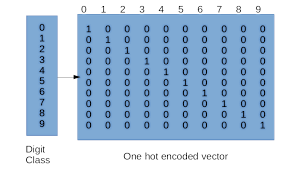

In [ ]:
y_train = np_utils.to_categorical(y_train)

### Reshaping

* Gray Scale Images
* Image Size - (28,28)

In [ ]:
m = X_train.shape[0]
n = test.shape[0]

X_train = X_train.values.reshape(m,28,28,1)
test = test.values.reshape(n,28,28,1)

### Splitting the Train Set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,7))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

# Modelling 

* Model architecture - [ [Conv2D * 2] -> BatchNormalization -> MaxPooling -> Dropout ] * 2 -> Flatten -> Dense -> Output
* We have taken default value for strides in convolution layer.
* 'he_uniform' method is used for weight initialization as it is preferrable method for relu activation function.
* 'Same' padding method is used as image size remains same.
* Batch Normalization layer is used to normalize the activation of the layers output.
* Dropout layer is used to reduce overfitting by randomly selecting the nodes of layer according to input termed as rate and deactivates them.

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer = 'he_uniform', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer = 'he_uniform'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation = "relu",kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation = "softmax",kernel_initializer = 'he_uniform'))

In [ ]:
model.summary()

In [ ]:
# Compile the model

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics =['accuracy'])

## Adding Callbacks

In [ ]:
# ModelCheckpoint

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('../working/mod.best.hdf5',monitor = 'val_loss', mode = "min", verbose = 1, save_best_model = True)

# EarlyStopping

from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0,verbose =1, restore_best_weights = True)

# ReduceLROnPlateau

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [reduce_lr,checkpoint]

## Data Augmentation

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Best model

model = load_model("../working/mod.best.hdf5")

In [ ]:
# Training the model

batch_size = 86
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size = 86),
                              epochs = 35, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks = callbacks)

## Evaluation

In [ ]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_val,axis=1)
CM = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(15,10))
sns.heatmap(CM,annot=True,cmap="viridis")
plt.tight_layout()

In [ ]:
# Evaluation

score = model.evaluate(X_val, y_val, verbose=0)
print("Val_Loss :",score[0])
print("Val_Acc :",score[1])

# Model Plotting

In [ ]:
# Plotting the model

from keras.utils.vis_utils import plot_model

plot_model(model,to_file="../working/plot.png",show_shapes=True,show_layer_names=True)


## Submission

In [ ]:
result = model.predict(test)
result = np.argmax(result,axis=1)

In [ ]:
submission["Label"] = result
submission.to_csv("CNN_Result",index=False)

## Thank You!!

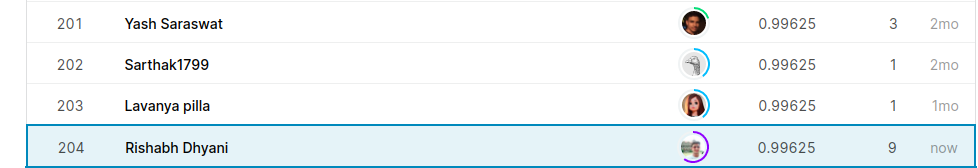